## Importing libraries

In [2]:
import PIL
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import keras
import skimage

from skimage import exposure
from PIL import Image,ImageOps,ImageFilter
from tensorflow.keras import Sequential

## Loading dataset

In [3]:
image = PIL.Image.open("Dataset/images/trainA/ct15.png")
image = image.resize((280,280))
image_array = np.array(image,dtype='float')
image_array = image_array.reshape(280,280,1)
image_array.shape,type(image_array)

((280, 280, 1), numpy.ndarray)

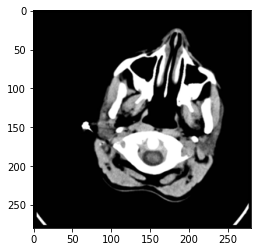

In [4]:
plt.imshow(image_array, cmap='gray')
plt.show()

In [5]:
image = Image.open("Dataset/unseen_demo_images/mri/mri313.jpg")
image = ImageOps.grayscale(image)
image = image.resize((280,280))
image_array = np.array(image,dtype='float')
image_array = image_array.reshape(280,280,1)
image_array.shape,type(image_array)

((280, 280, 1), numpy.ndarray)

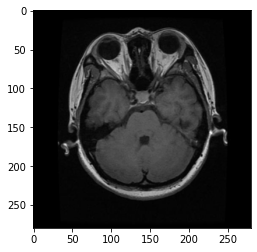

In [6]:
plt.imshow(image_array, cmap='gray')
plt.show()

In [7]:
path = "Dataset/unseen_demo_images/mri/mri313.jpg"
img = cv2.imread(path)

In [8]:
cv2.imshow("Image", img)

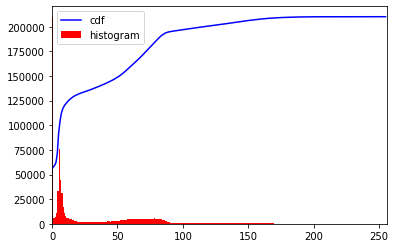

In [9]:
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [10]:
def calculate_cdf(histogram):
    """
    This method calculates the cumulative distribution function
    :param array histogram: The values of the histogram
    :return: normalized_cdf: The normalized cumulative distribution function
    :rtype: array
    """
    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()
 
    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())
 
    return normalized_cdf
 
def calculate_lookup(src_cdf, ref_cdf):
    """
    This method creates the lookup table
    :param array src_cdf: The cdf for the source image
    :param array ref_cdf: The cdf for the reference image
    :return: lookup_table: The lookup table
    :rtype: array
    """
    lookup_table = np.zeros(256)
    lookup_val = 0
    for src_pixel_val in range(len(src_cdf)):
        lookup_val
        for ref_pixel_val in range(len(ref_cdf)):
            if ref_cdf[ref_pixel_val] >= src_cdf[src_pixel_val]:
                lookup_val = ref_pixel_val
                break
        lookup_table[src_pixel_val] = lookup_val
    return lookup_table
 
def match_histograms(src_image, ref_image):
    """
    This method matches the source image histogram to the
    reference signal
    :param image src_image: The original source image
    :param image  ref_image: The reference image
    :return: image_after_matching
    :rtype: image (array)
    """
    # Split the images into the different color channels
    # b means blue, g means green and r means red
    src_b, src_g, src_r = cv2.split(src_image)
    ref_b, ref_g, ref_r = cv2.split(ref_image)
 
    # Compute the b, g, and r histograms separately
    # The flatten() Numpy method returns a copy of the array c
    # collapsed into one dimension.
    src_hist_blue, bin_0 = np.histogram(src_b.flatten(), 256, [0,256])
    src_hist_green, bin_1 = np.histogram(src_g.flatten(), 256, [0,256])
    src_hist_red, bin_2 = np.histogram(src_r.flatten(), 256, [0,256])    
    ref_hist_blue, bin_3 = np.histogram(ref_b.flatten(), 256, [0,256])    
    ref_hist_green, bin_4 = np.histogram(ref_g.flatten(), 256, [0,256])
    ref_hist_red, bin_5 = np.histogram(ref_r.flatten(), 256, [0,256])
 
    # Compute the normalized cdf for the source and reference image
    src_cdf_blue = calculate_cdf(src_hist_blue)
    src_cdf_green = calculate_cdf(src_hist_green)
    src_cdf_red = calculate_cdf(src_hist_red)
    ref_cdf_blue = calculate_cdf(ref_hist_blue)
    ref_cdf_green = calculate_cdf(ref_hist_green)
    ref_cdf_red = calculate_cdf(ref_hist_red)
 
    # Make a separate lookup table for each color
    blue_lookup_table = calculate_lookup(src_cdf_blue, ref_cdf_blue)
    green_lookup_table = calculate_lookup(src_cdf_green, ref_cdf_green)
    red_lookup_table = calculate_lookup(src_cdf_red, ref_cdf_red)
 
    # Use the lookup function to transform the colors of the original
    # source image
    blue_after_transform = cv2.LUT(src_b, blue_lookup_table)
    green_after_transform = cv2.LUT(src_g, green_lookup_table)
    red_after_transform = cv2.LUT(src_r, red_lookup_table)
 
    # Put the image back together
    image_after_matching = cv2.merge([
        blue_after_transform, green_after_transform, red_after_transform])
    image_after_matching = cv2.convertScaleAbs(image_after_matching)
 
    return image_after_matching

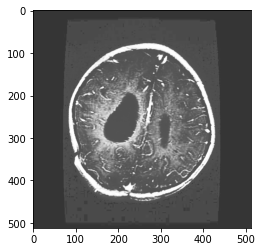

In [11]:
src = cv2.imread(("Dataset/images/trainB/mri61.jpg"))
ref = cv2.imread("Dataset/images/trainB/mri62.jpg")
output_image = match_histograms(src, ref)
plt.imshow(output_image)
plt.show()

In [11]:
src = cv2.imread(("Dataset/images/trainB/mri61.jpg"))
ref = cv2.imread("Dataset/images/trainB/mri62.jpg")

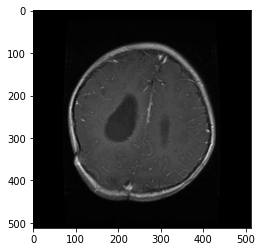

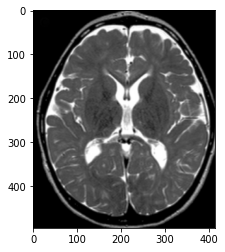

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


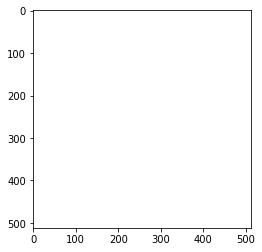

In [12]:
multi = True if src.shape[-1] > 1 else False
matched = exposure.match_histograms(src, ref, channel_axis = None)

plt.imshow(src)
plt.show()
plt.imshow(ref)
plt.show()
plt.imshow(matched)
plt.show()

In [11]:
def load_ct_from_folder(folder):
    images = []
    for filename in os.listdir(folder)[:]:
        image = PIL.Image.open(os.path.join(folder,filename))
        image = image.resize((276,276))
        image_array = np.array(image,dtype='float')
        image_array = image_array.reshape(276,276,1)
        if image is not None:
            images.append(image_array)
    return np.array(images,dtype=float)

def load_mri_from_folder(folder):
    images = []
    for filename in os.listdir(folder)[:1742]:
        image = Image.open(os.path.join(folder,filename))
        image = ImageOps.grayscale(image)
        image = image.filter(ImageFilter.SHARPsEN)
        image = image.resize((276,276))
        image_array = np.array(image,dtype='float')
        image_array = image_array.reshape(276,276,1)
        if image is not None:
            images.append(image_array)
    return np.array(images,dtype=float)

In [14]:
x_train_A = load_ct_from_folder("Dataset/images/trainA")
x_train_B = load_mri_from_folder("Dataset/images/trainB")
x_test_A = load_ct_from_folder("Dataset/images/testA")
x_test_B = load_mri_from_folder("Dataset/images/testB")

In [15]:
np.save("x_train_A.npy",x_train_A)
np.save("x_train_B.npy",x_train_B)
np.save("x_test_A.npy",x_test_A)
np.save("x_test_B.npy",x_test_B)

In [16]:
x_train_A = x_train_A.astype('float32') / 255.
x_train_B = x_train_B.astype('float32') / 255.
x_test_A = x_test_A.astype('float32') / 255.
x_test_B = x_test_B.astype('float32') / 255.

In [17]:
x_train_A.shape,x_train_B.shape,x_test_B.shape,x_test_B.shape

((1742, 276, 276, 1),
 (1742, 276, 276, 1),
 (744, 276, 276, 1),
 (744, 276, 276, 1))

## Training model

In [26]:
input_img = keras.Input(shape=(276, 276, 1))

x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = keras.layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = keras.layers.UpSampling2D((2, 2))(x)
print(x.shape)
x = keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
print(x.shape)
x = keras.layers.UpSampling2D((2, 2))(x)
print(x.shape)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(None, 276, 276, 16)
(None, 138, 138, 16)
(None, 138, 138, 8)
(None, 69, 69, 8)
(None, 69, 69, 8)
(None, 35, 35, 8)
(None, 35, 35, 8)
(None, 70, 70, 8)
(None, 70, 70, 8)
(None, 140, 140, 8)
(None, 138, 138, 16)
(None, 276, 276, 16)
KerasTensor(type_spec=TensorSpec(shape=(None, 276, 276, 1), dtype=tf.float32, name=None), name='conv2d_10/Sigmoid:0', description="created by layer 'conv2d_10'")


In [27]:
history = autoencoder.fit(x_train_B, x_train_A,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_B, x_test_A))

2022-01-28 15:09:57.666701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
14/14 [==============================] - 68s 5s/step - loss: 0.6546 - val_loss: 0.6018
Epoch 2/100
14/14 [==============================] - 62s 4s/step - loss: 0.5361 - val_loss: 0.4448
Epoch 3/100
14/14 [==============================] - 66s 5s/step - loss: 0.4257 - val_loss: 0.4238
Epoch 4/100
14/14 [==============================] - 58s 4s/step - loss: 0.4192 - val_loss: 0.4151
Epoch 5/100
14/14 [==============================] - 56s 4s/step - loss: 0.4141 - val_loss: 0.4130
Epoch 6/100
14/14 [==============================] - 56s 4s/step - loss: 0.4119 - val_loss: 0.4104
Epoch 7/100
14/14 [==============================] - 56s 4s/step - loss: 0.4095 - val_loss: 0.4093
Epoch 8/100
14/14 [==============================] - 57s 4s/step - loss: 0.4090 - val_loss: 0.4081
Epoch 9/100
14/14 [==============================] - 57s 4s/step - loss: 0.4061 - val_loss: 0.4053
Epoch 10/100
14/14 [==============================] - 56s 4s/step - loss: 0.4045 - val_loss: 0.4038
Epoch 11/

14/14 [==============================] - 60s 4s/step - loss: 0.3913 - val_loss: 0.3904
Epoch 84/100
14/14 [==============================] - 60s 4s/step - loss: 0.3904 - val_loss: 0.3907
Epoch 85/100
14/14 [==============================] - 59s 4s/step - loss: 0.3900 - val_loss: 0.3899
Epoch 86/100
14/14 [==============================] - 61s 4s/step - loss: 0.3900 - val_loss: 0.3926
Epoch 87/100
14/14 [==============================] - 64s 5s/step - loss: 0.3900 - val_loss: 0.3897
Epoch 88/100
14/14 [==============================] - 61s 4s/step - loss: 0.3900 - val_loss: 0.3905
Epoch 89/100
14/14 [==============================] - 60s 4s/step - loss: 0.3903 - val_loss: 0.3916
Epoch 90/100
14/14 [==============================] - 62s 4s/step - loss: 0.3915 - val_loss: 0.3896
Epoch 91/100
14/14 [==============================] - 63s 5s/step - loss: 0.3902 - val_loss: 0.3897
Epoch 92/100
14/14 [==============================] - 67s 5s/step - loss: 0.3898 - val_loss: 0.3896
Epoch 93/100


In [10]:
autoencoder.save("autoencoderSharp")
from keras.models import load_model
autoencoder=load_model("autoencoderSharp")

NameError: name 'autoencoder' is not defined

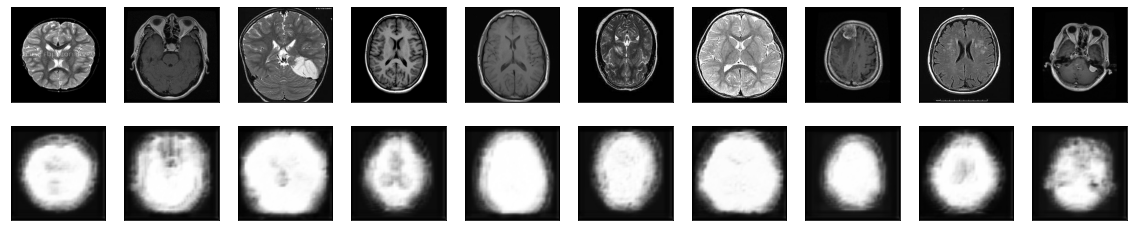

In [29]:
decoded_imgs = autoencoder.predict(x_test_B)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_B[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
unseen = load_ct_from_folder("Dataset/unseen_demo_images/ct")

In [31]:
unseen_ct_imgs = autoencoder.predict(unseen)

In [32]:
unseen_ct_imgs.shape

(15, 276, 276, 1)

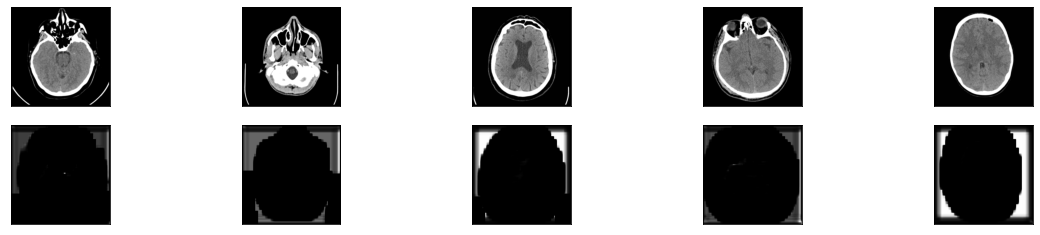

In [33]:
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(unseen[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(unseen_ct_imgs[i].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [36]:
#encoder model
model=tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16,(3,3),activation ='relu', input_shape=(521,521,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(8,(3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(8,(3,3),activation ='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),   
 ])

In [37]:
def visualize(img,encoder):
    code = encoder.predict(img[None])[0]
    
    # Display original
    plt.title("MRI Scan")
    plt.imshow(unseen[0].reshape(276, 276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    #Display compressed
    plt.subplot(1,3,2)
    plt.title("intermediate encoded")
    plt.imshow(code.reshape([code.shape[-1]//32,-1]))
    plt.show()

    # Display reconstruction
    plt.title("Corresponding CT")
    plt.imshow(unseen_ct_imgs[0].reshape(276,276))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

visualize(x_test_B[0],model)

ValueError: in user code:

    File "/opt/homebrew/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/opt/homebrew/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/lib/python3.9/site-packages/keras/engine/input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 521, 521, 1), found shape=(None, 276, 276, 1)


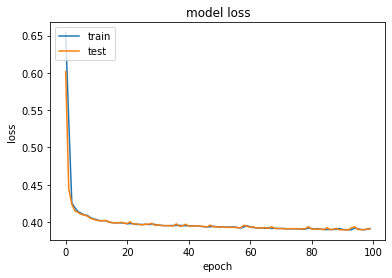

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()